In [1]:
import os 
fname = './jena_climate_2009_2016.csv'

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
headers = lines[0].split(',')
lines = lines[1:]

print('\n'.join(headers))
print(len(lines))

"Date Time"
"p (mbar)"
"T (degC)"
"Tpot (K)"
"Tdew (degC)"
"rh (%)"
"VPmax (mbar)"
"VPact (mbar)"
"VPdef (mbar)"
"sh (g/kg)"
"H2OC (mmol/mol)"
"rho (g/m**3)"
"wv (m/s)"
"max. wv (m/s)"
"wd (deg)"
420551


In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(headers)-1))
for i,line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

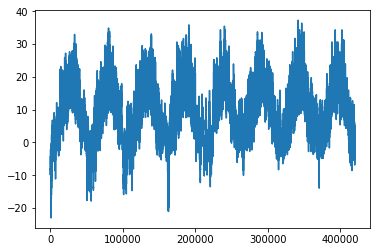

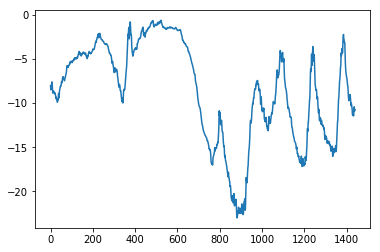

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

temp = float_data[:,1] 
plt.plot(range(len(temp)), temp)
plt.figure()

plt.plot(range(1440), temp[:1440])

In [4]:
mean = float_data[:200_000].mean(axis=0)
float_data -= mean
std = float_data[:200_000].std(axis=0)
float_data /= std

In [5]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index==None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index+lookback , max_index, size=batch_size)
        else :
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i , min(i+batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros(len(rows),)
        
        for j,row in enumerate(rows):
            indices = range(rows[j]-lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j]+delay][1]
        yield samples,targets

In [6]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, min_index=0, max_index=200_000,shuffle=True, batch_size=batch_size, step=step, delay=delay)
val_gen = generator(float_data, lookback=lookback, min_index=200_001, max_index=300_000, batch_size=batch_size, step=step, delay=delay)
test_gen = generator(float_data, lookback=lookback, min_index=300_001, max_index=None, batch_size=batch_size, step=step, delay=delay)

val_steps = 300_000 - 200_001 - lookback
test_steps = len(float_data) - 300_001 - lookback

In [ ]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples , targets = next(val_gen)
        preds = samples[:,-1,1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes)*std[1])
    
evaluate_naive_method()

In [20]:
from keras.models import Sequential
from keras.layers import Flatten,Dense
from keras.optimizers import RMSprop

model = Sequential()
model.add(Flatten(input_shape=(lookback//step, float_data.shape[-1])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(loss='mae', optimizer=RMSprop())

history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data = val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 982s 2s/step - loss: 1.4348 - val_loss: 0.8461
Epoch 2/20
500/500 [==============================] - 1115s 2s/step - loss: 0.4784 - val_loss: 0.3636
Epoch 3/20
500/500 [==============================] - 1080s 2s/step - loss: 0.2976 - val_loss: 0.3085
Epoch 4/20
500/500 [==============================] - 1069s 2s/step - loss: 0.2680 - val_loss: 0.3063
Epoch 5/20
500/500 [==============================] - 1022s 2s/step - loss: 0.2524 - val_loss: 0.3762
Epoch 6/20
500/500 [==============================] - 1051s 2s/step - loss: 0.2435 - val_loss: 0.3266
Epoch 7/20
500/500 [==============================] - 988s 2s/step - loss: 0.2364 - val_loss: 0.3458
Epoch 8/20
500/500 [==============================] - 999s 2s/step - loss: 0.2303 - val_loss: 0.3209
Epoch 9/20
500/500 [==============================] - 993s 2s/step - loss: 0.2262 - val_loss: 0.3208
Epoch 10/20
500/500 [==============================] - 972s 2s/step - loss: 0.2235 - v

dict_keys(['val_loss', 'loss'])


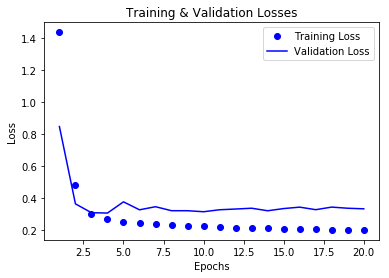

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

history_dict = history.history
print(history_dict.keys())

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1,len(history_dict['loss'])+1)

plt.plot(epochs, loss_values,'bo', label='Training Loss')
plt.plot(epochs, val_loss_values,'b', label='Validation Loss')
plt.title('Training & Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [23]:
from keras.layers import GRU

model = Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1]) ))
model.add(Dense(1))

model.compile(loss='mae', optimizer=RMSprop())

history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data = val_gen, validation_steps=val_steps//10)

Epoch 1/20
500/500 [==============================] - 515s 1s/step - loss: 0.3020 - val_loss: 0.2709
Epoch 2/20
500/500 [==============================] - 520s 1s/step - loss: 0.2823 - val_loss: 0.2668
Epoch 3/20
500/500 [==============================] - 521s 1s/step - loss: 0.2777 - val_loss: 0.2796
Epoch 4/20
500/500 [==============================] - 520s 1s/step - loss: 0.2747 - val_loss: 0.2683
Epoch 5/20
500/500 [==============================] - 520s 1s/step - loss: 0.2682 - val_loss: 0.2694
Epoch 6/20
500/500 [==============================] - 522s 1s/step - loss: 0.2668 - val_loss: 0.2712
Epoch 7/20
500/500 [==============================] - 522s 1s/step - loss: 0.2623 - val_loss: 0.2707
Epoch 8/20
500/500 [==============================] - 524s 1s/step - loss: 0.2572 - val_loss: 0.2802
Epoch 9/20
500/500 [==============================] - 524s 1s/step - loss: 0.2535 - val_loss: 0.2728
Epoch 10/20
500/500 [==============================] - 525s 1s/step - loss: 0.2494 - val_lo

dict_keys(['val_loss', 'loss'])


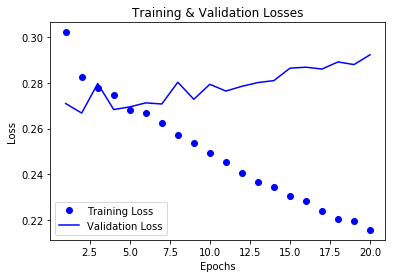

In [24]:
history_dict = history.history
print(history_dict.keys())

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1,len(history_dict['loss'])+1)

plt.plot(epochs, loss_values,'bo', label='Training Loss')
plt.plot(epochs, val_loss_values,'b', label='Validation Loss')
plt.title('Training & Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [26]:
model = Sequential()
model.add(GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1]) ))
model.add(Dense(1))

model.compile(loss='mae', optimizer=RMSprop())

history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data = val_gen, validation_steps=val_steps//100)

Epoch 1/40
500/500 [==============================] - 130s 260ms/step - loss: 0.3441 - val_loss: 0.2822
Epoch 2/40
500/500 [==============================] - 133s 266ms/step - loss: 0.3142 - val_loss: 0.2751
Epoch 3/40
500/500 [==============================] - 134s 268ms/step - loss: 0.3093 - val_loss: 0.2664
Epoch 4/40
500/500 [==============================] - 135s 270ms/step - loss: 0.3029 - val_loss: 0.2688
Epoch 5/40
500/500 [==============================] - 136s 272ms/step - loss: 0.3000 - val_loss: 0.2748
Epoch 6/40
500/500 [==============================] - 136s 272ms/step - loss: 0.2977 - val_loss: 0.2647
Epoch 7/40
500/500 [==============================] - 136s 272ms/step - loss: 0.2964 - val_loss: 0.2640
Epoch 8/40
500/500 [==============================] - 136s 272ms/step - loss: 0.2940 - val_loss: 0.2711
Epoch 9/40
500/500 [==============================] - 136s 273ms/step - loss: 0.2946 - val_loss: 0.2705
Epoch 10/40
500/500 [==============================] - 137s 273m

dict_keys(['val_loss', 'loss'])


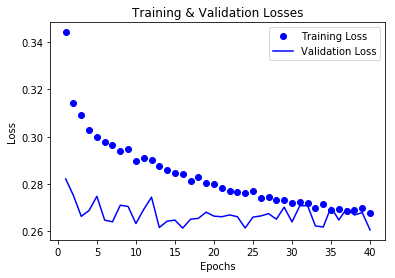

In [27]:
history_dict = history.history
print(history_dict.keys())

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1,len(history_dict['loss'])+1)

plt.plot(epochs, loss_values,'bo', label='Training Loss')
plt.plot(epochs, val_loss_values,'b', label='Validation Loss')
plt.title('Training & Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [28]:
model = Sequential()
model.add(GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(None, float_data.shape[-1]) ))
model.add(GRU(64, dropout=0.1, recurrent_dropout=0.5 ))
model.add(Dense(1))

model.compile(loss='mae', optimizer=RMSprop())

history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=40, validation_data = val_gen, validation_steps=val_steps//100)

Epoch 1/40
500/500 [==============================] - 360s 720ms/step - loss: 0.3428 - val_loss: 0.2808
Epoch 2/40
500/500 [==============================] - 380s 761ms/step - loss: 0.3180 - val_loss: 0.2894
Epoch 3/40
500/500 [==============================] - 385s 770ms/step - loss: 0.3117 - val_loss: 0.2676
Epoch 4/40
500/500 [==============================] - 384s 768ms/step - loss: 0.3056 - val_loss: 0.2754
Epoch 5/40
500/500 [==============================] - 387s 773ms/step - loss: 0.3033 - val_loss: 0.2687
Epoch 6/40
500/500 [==============================] - 381s 762ms/step - loss: 0.3007 - val_loss: 0.2702
Epoch 7/40
500/500 [==============================] - 381s 762ms/step - loss: 0.2974 - val_loss: 0.2597
Epoch 8/40
500/500 [==============================] - 380s 760ms/step - loss: 0.2938 - val_loss: 0.2670
Epoch 9/40
500/500 [==============================] - 381s 762ms/step - loss: 0.2929 - val_loss: 0.2689
Epoch 10/40
500/500 [==============================] - 382s 764m

dict_keys(['val_loss', 'loss'])


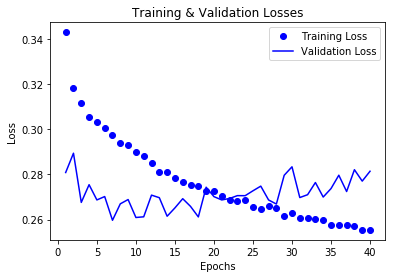

In [29]:
history_dict = history.history
print(history_dict.keys())

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1,len(loss_values)+1)

plt.plot(epochs, loss_values,'bo', label='Training Loss')
plt.plot(epochs, val_loss_values,'b', label='Validation Loss')
plt.title('Training & Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [47]:
def generator2(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index==None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index+lookback , max_index, size=batch_size)
        else :
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i , min(i+batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros(len(rows),)
        
        for j,row in enumerate(rows):
            indices = range(rows[j]-lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j]+delay][1]
        yield samples[:,::-1,:],targets

In [48]:
train_gen2 = generator2(float_data, lookback=lookback, min_index=0, max_index=200_000,shuffle=True, batch_size=batch_size, step=step, delay=delay)
val_gen2 = generator2(float_data, lookback=lookback, min_index=200_001, max_index=300_000, batch_size=batch_size, step=step, delay=delay)

In [49]:
model = Sequential()
model.add(GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1]) ))
model.add(Dense(1))

model.compile(loss='mae', optimizer=RMSprop())

history = model.fit_generator(train_gen2, steps_per_epoch=500, epochs=40, validation_data = val_gen2, validation_steps=val_steps//100)

Epoch 1/40
500/500 [==============================] - 124s 247ms/step - loss: 0.5045 - val_loss: 0.5069
Epoch 2/40
500/500 [==============================] - 128s 256ms/step - loss: 0.4764 - val_loss: 0.4587
Epoch 3/40
500/500 [==============================] - 130s 261ms/step - loss: 0.4550 - val_loss: 0.4368
Epoch 4/40
500/500 [==============================] - 132s 264ms/step - loss: 0.4349 - val_loss: 0.4073
Epoch 5/40
500/500 [==============================] - 140s 280ms/step - loss: 0.4106 - val_loss: 0.3876
Epoch 6/40
500/500 [==============================] - 132s 264ms/step - loss: 0.3789 - val_loss: 0.3386
Epoch 7/40
500/500 [==============================] - 131s 263ms/step - loss: 0.3557 - val_loss: 0.3408
Epoch 8/40
500/500 [==============================] - 133s 266ms/step - loss: 0.3378 - val_loss: 0.2999
Epoch 9/40
500/500 [==============================] - 132s 264ms/step - loss: 0.3137 - val_loss: 0.2878
Epoch 10/40
500/500 [==============================] - 133s 266m

dict_keys(['val_loss', 'loss'])


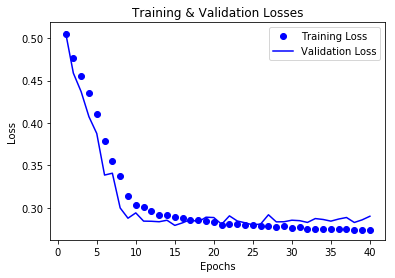

In [50]:
history_dict = history.history
print(history_dict.keys())

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1,len(loss_values)+1)

plt.plot(epochs, loss_values,'bo', label='Training Loss')
plt.plot(epochs, val_loss_values,'b', label='Validation Loss')
plt.title('Training & Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [51]:
from keras.layers import Bidirectional

model = Sequential()
model.add(Bidirectional(GRU(32), input_shape=(None, float_data.shape[-1]) ))
model.add(Dense(1))

model.compile(loss='mae', optimizer=RMSprop())

history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data = val_gen, validation_steps=val_steps//10)

Epoch 1/20
500/500 [==============================] - 805s 2s/step - loss: 0.2932 - val_loss: 0.2703
Epoch 2/20
500/500 [==============================] - 800s 2s/step - loss: 0.2746 - val_loss: 0.2827
Epoch 3/20
500/500 [==============================] - 799s 2s/step - loss: 0.2656 - val_loss: 0.2774
Epoch 4/20
500/500 [==============================] - 800s 2s/step - loss: 0.2615 - val_loss: 0.2703
Epoch 5/20
500/500 [==============================] - 798s 2s/step - loss: 0.2550 - val_loss: 0.2693
Epoch 6/20
500/500 [==============================] - 797s 2s/step - loss: 0.2493 - val_loss: 0.2713
Epoch 7/20
500/500 [==============================] - 796s 2s/step - loss: 0.2440 - val_loss: 0.2754
Epoch 8/20
500/500 [==============================] - 798s 2s/step - loss: 0.2375 - val_loss: 0.2779
Epoch 9/20
500/500 [==============================] - 796s 2s/step - loss: 0.2303 - val_loss: 0.2864
Epoch 10/20
500/500 [==============================] - 797s 2s/step - loss: 0.2264 - val_lo

dict_keys(['val_loss', 'loss'])


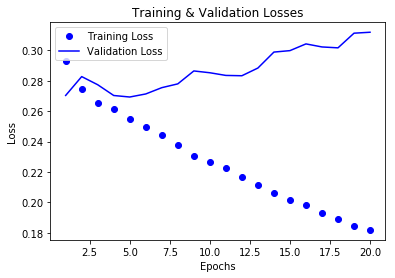

In [52]:
history_dict = history.history
print(history_dict.keys())

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1,len(loss_values)+1)

plt.plot(epochs, loss_values,'bo', label='Training Loss')
plt.plot(epochs, val_loss_values,'b', label='Validation Loss')
plt.title('Training & Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()